In [ ]:
#파일 업로드
from google.colab import files
uploaded = files.upload()

# 업로드된 파일 목록 확인
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving all_stocks_5yr.csv to all_stocks_5yr.csv
User uploaded file "all_stocks_5yr.csv" with length 29580549 bytes


In [ ]:
# 데이터 처리를 위한 pandas 라이브러리를 pd라는 이름으로 가져옵니다.
import pandas as pd

# 수치 계산을 위한 numpy 라이브러리를 np라는 이름으로 가져옵니다.
import numpy as np

# 데이터 정규화를 위한 MinMaxScaler를 가져옵니다.
from sklearn.preprocessing import MinMaxScaler

# 그래프를 그리기 위한 matplotlib의 pyplot 모듈을 plt라는 이름으로 가져옵니다.
import matplotlib.pyplot as plt



In [ ]:
# CSV 파일 불러오기
data = pd.read_csv('all_stocks_5yr.csv')

# 데이터의 처음 5행을 출력하여 파일이 올바르게 불러와졌는지 확인합니다.
print(data.head())


         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL


In [ ]:
# 결측치가 있는 행을 제거합니다.
data = data.dropna()

# 'AAPL' 주식의 데이터를 선택합니다.
stock_data = data[data['Name'] == 'AAPL']

# 'date' 컬럼을 datetime 타입으로 변환합니다.
stock_data['date'] = pd.to_datetime(stock_data['date'])

# 'date'를 기준으로 데이터를 정렬합니다.
stock_data = stock_data.sort_values('date')

# 'date' 컬럼을 인덱스로 설정합니다.
stock_data.set_index('date', inplace=True)


<ipython-input-5-6e0fbb0c5b78>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['date'] = pd.to_datetime(stock_data['date'])


In [ ]:
# 종가(close)만 사용하여 데이터를 정규화합니다.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['close'].values.reshape(-1, 1))

# 학습 데이터를 생성하는 함수를 정의합니다.
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        # time_step 길이만큼의 시퀀스를 만듭니다.
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        # 시퀀스의 다음 값을 예측 값으로 설정합니다.
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 시퀀스 길이를 60으로 설정합니다.
time_step = 60

# 시퀀스 데이터를 생성합니다.
X, y = create_dataset(scaled_data, time_step)

# 학습 데이터와 테스트 데이터로 분리합니다 (80% 학습, 20% 테스트).
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 데이터 형태를 LSTM 입력 형태에 맞게 변환합니다 [samples, time steps, features].
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 학습 데이터와 테스트 데이터의 형태를 출력합니다.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(958, 60, 1) (958,)
(240, 60, 1) (240,)


In [ ]:
# Keras 라이브러리에서 필요한 모듈을 가져옵니다.
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# LSTM 모델을 구축합니다.
model = Sequential()

# 첫 번째 LSTM 층을 추가합니다. (units=50, return_sequences=True, input_shape=(time_step, 1))
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

# 두 번째 LSTM 층을 추가합니다. (units=50, return_sequences=False)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# 출력 층을 추가합니다. (units=1)
model.add(Dense(units=1))

# 모델을 컴파일합니다. (optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델을 훈련합니다. (epochs=10, batch_size=32, verbose=1)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# 테스트 데이터를 사용하여 예측을 수행합니다.
predicted_stock_price = model.predict(X_test)

# 예측된 주가를 원래 스케일로 되돌립니다.
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


Epoch 1/10
30/30 [==============================] - 6s 53ms/step - loss: 0.0261
Epoch 2/10
30/30 [==============================] - 2s 52ms/step - loss: 0.0035
Epoch 3/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0026
Epoch 4/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0023
Epoch 5/10
30/30 [==============================] - 3s 88ms/step - loss: 0.0020
Epoch 6/10
30/30 [==============================] - 2s 77ms/step - loss: 0.0019
Epoch 7/10
30/30 [==============================] - 2s 53ms/step - loss: 0.0019
Epoch 8/10
30/30 [==============================] - 2s 54ms/step - loss: 0.0018
Epoch 9/10
30/30 [==============================] - 2s 53ms/step - loss: 0.0019
Epoch 10/10
8/8 [==============================] - 1s 16ms/step


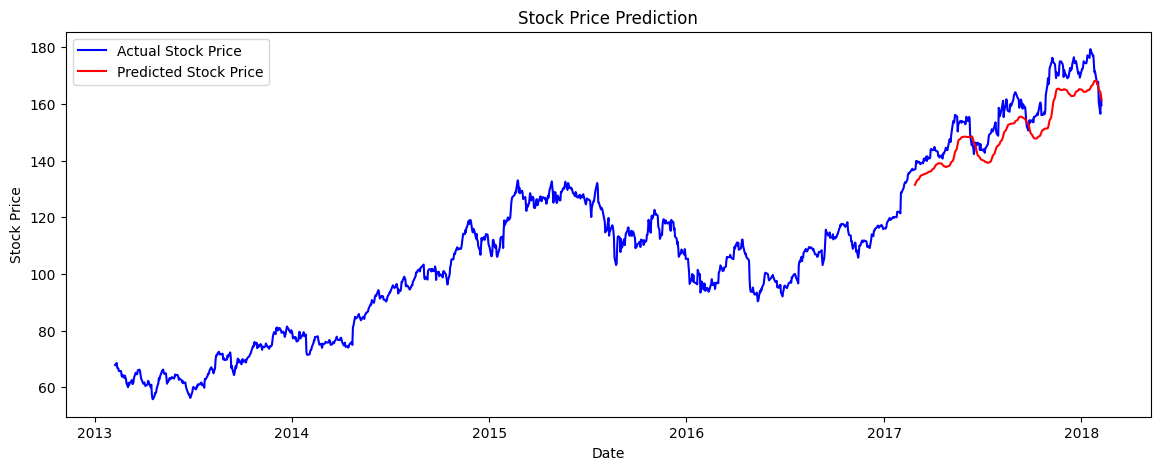

In [ ]:
# 실제 주가와 예측된 주가를 시각화하기 위해 matplotlib와 datetime 모듈을 가져옵니다.
import matplotlib.pyplot as plt
import datetime

# 실제 주가와 예측된 주가 시각화
plt.figure(figsize=(14, 5))
plt.plot(stock_data.index, stock_data['close'], color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[-len(y_test):], predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


1/1 [==============================] - 0s 37ms/step


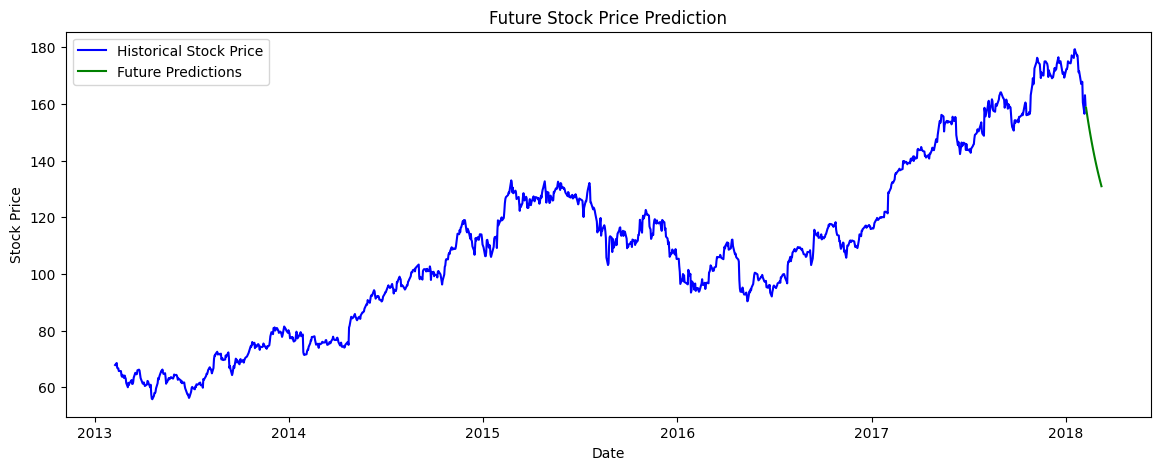

In [ ]:
# 미래 주가를 예측할 일 수를 설정합니다 (예: 30일).
future_days = 30
future_predictions = []

# 마지막 시퀀스를 가져옵니다.
last_sequence = scaled_data[-time_step:]
current_sequence = last_sequence

# 미래 주가를 예측합니다.
for _ in range(future_days):
    # 현재 시퀀스를 사용하여 다음 값을 예측합니다.
    next_prediction = model.predict(current_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_prediction[0, 0])
    # 시퀀스에서 가장 오래된 값을 제거하고, 새로운 예측 값을 추가합니다.
    current_sequence = np.append(current_sequence[1:], next_prediction, axis=0)

# future_predictions 리스트를 NumPy 배열로 변환합니다.
future_predictions = np.array(future_predictions)

# 예측된 미래 주가를 원래 스케일로 되돌립니다.
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# 마지막 날짜부터 미래 날짜를 생성합니다.
last_date = stock_data.index[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# 예측 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(stock_data.index, stock_data['close'], color='blue', label='Historical Stock Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')
plt.title('Future Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


1/1 [==============================] - 0s 36ms/step


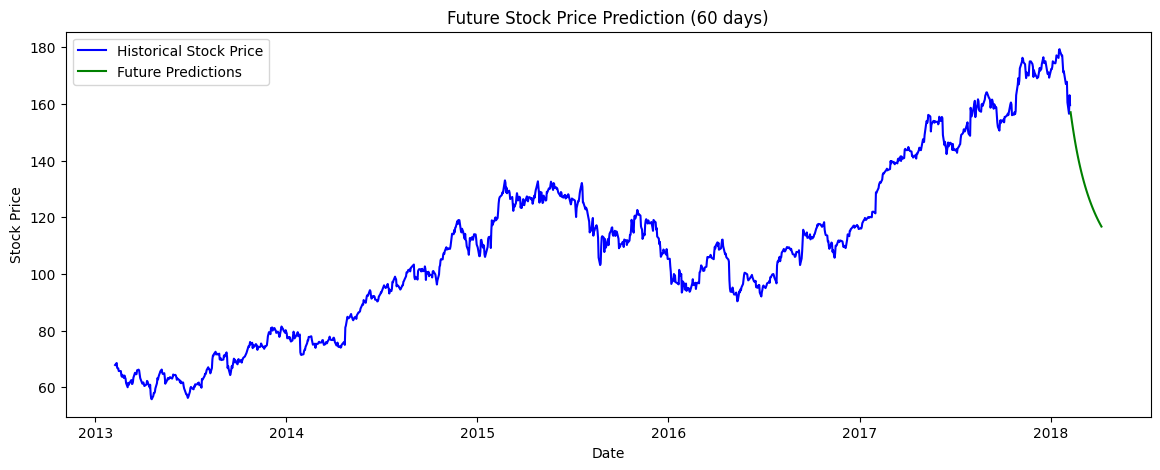

In [ ]:
# 미래 주가를 예측할 일 수를 60일로 설정합니다.
future_days = 60
future_predictions = []

# 마지막 시퀀스를 가져옵니다.
last_sequence = scaled_data[-time_step:]
current_sequence = last_sequence

# 60일 동안 미래 주가를 예측합니다.
for _ in range(future_days):
    # 현재 시퀀스를 사용하여 다음 값을 예측합니다.
    next_prediction = model.predict(current_sequence.reshape(1, time_step, 1))
    future_predictions.append(next_prediction[0, 0])
    # 시퀀스에서 가장 오래된 값을 제거하고, 새로운 예측 값을 추가합니다.
    current_sequence = np.append(current_sequence[1:], next_prediction, axis=0)

# future_predictions 리스트를 NumPy 배열로 변환합니다.
future_predictions = np.array(future_predictions)

# 예측된 미래 주가를 원래 스케일로 되돌립니다.
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# 마지막 날짜부터 미래 날짜를 생성합니다.
last_date = stock_data.index[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

# 예측 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(stock_data.index, stock_data['close'], color='blue', label='Historical Stock Price')
plt.plot(future_dates, future_predictions, color='green', label='Future Predictions')
plt.title('Future Stock Price Prediction (60 days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


8/8 [==============================] - 2s 26ms/step
Units: 50, Dropout: 0.2


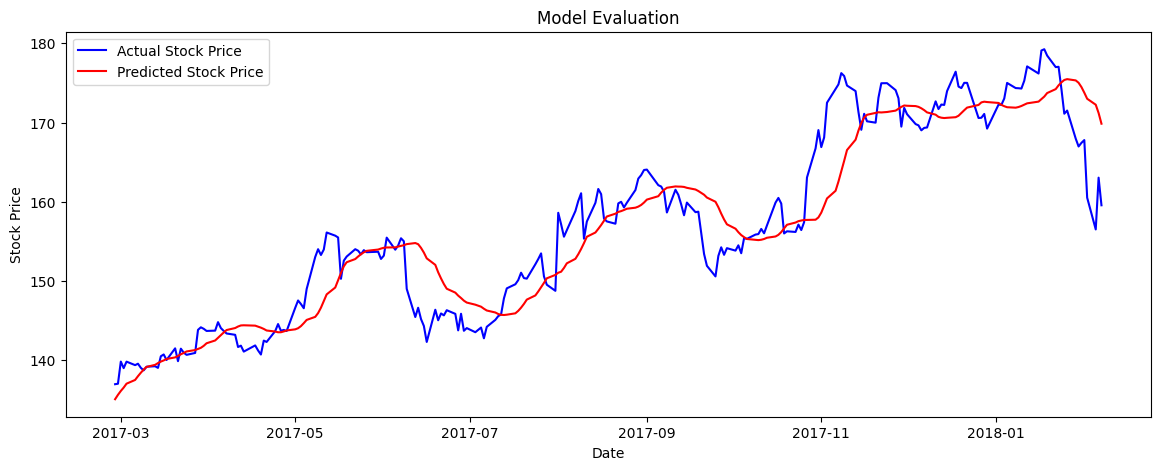

8/8 [==============================] - 1s 16ms/step
Units: 50, Dropout: 0.5


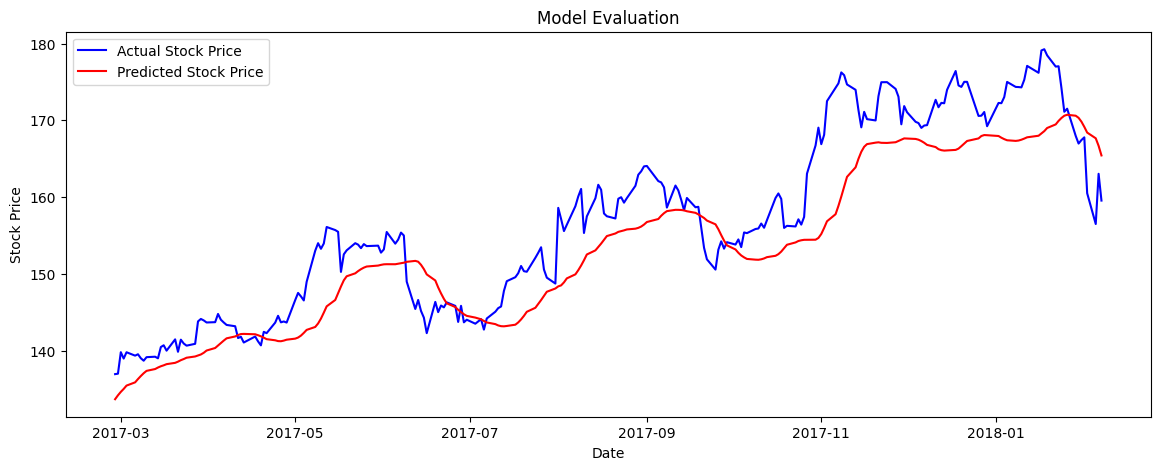

8/8 [==============================] - 1s 29ms/step
Units: 100, Dropout: 0.2


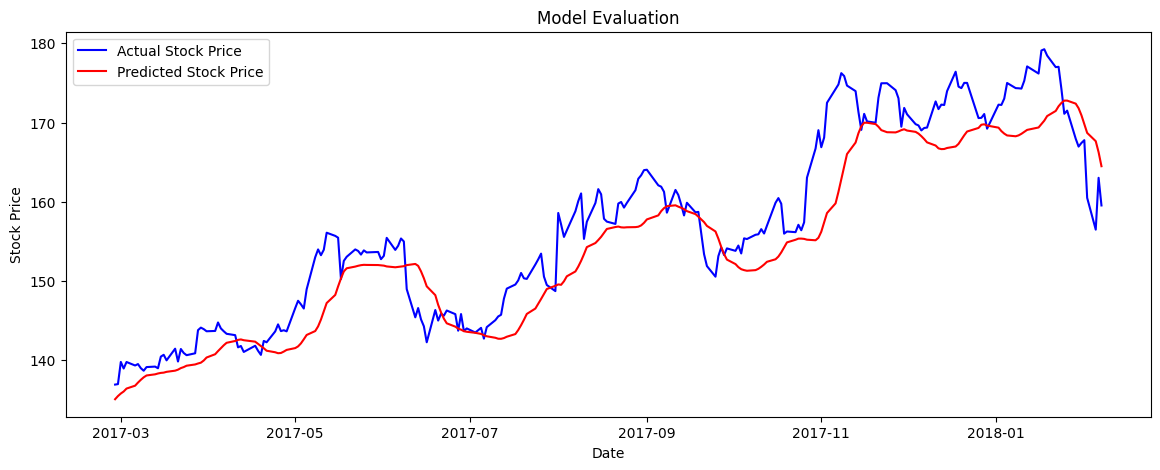

8/8 [==============================] - 2s 34ms/step
Units: 100, Dropout: 0.5


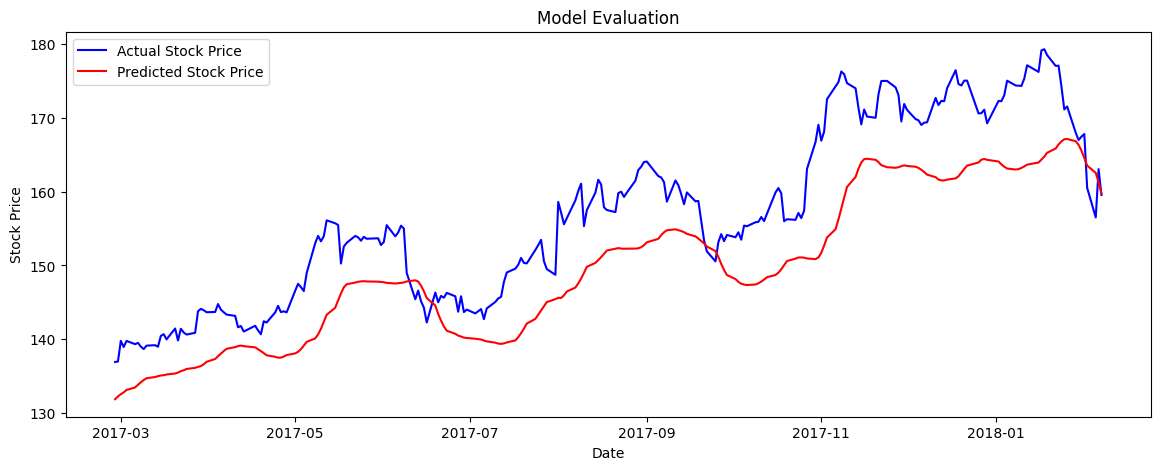

In [ ]:
# 모델을 평가하는 함수를 정의합니다.
def evaluate_model(actual, predicted):
    plt.figure(figsize=(14, 5))
    plt.plot(stock_data.index[-len(actual):], actual, color='blue', label='Actual Stock Price')
    plt.plot(stock_data.index[-len(predicted):], predicted, color='red', label='Predicted Stock Price')
    plt.title('Model Evaluation')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# 다양한 LSTM 모델을 구성하고 평가합니다.
def build_model(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 유닛 수와 드롭아웃 비율의 조합을 정의합니다.
units_options = [50, 100]
dropout_options = [0.2, 0.5]

# 각 조합에 대해 모델을 훈련시키고 평가합니다.
for units in units_options:
    for dropout_rate in dropout_options:
        model = build_model(units, dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        print(f'Units: {units}, Dropout: {dropout_rate}')
        evaluate_model(stock_data['close'][-len(y_test):].values, predicted_stock_price.flatten())


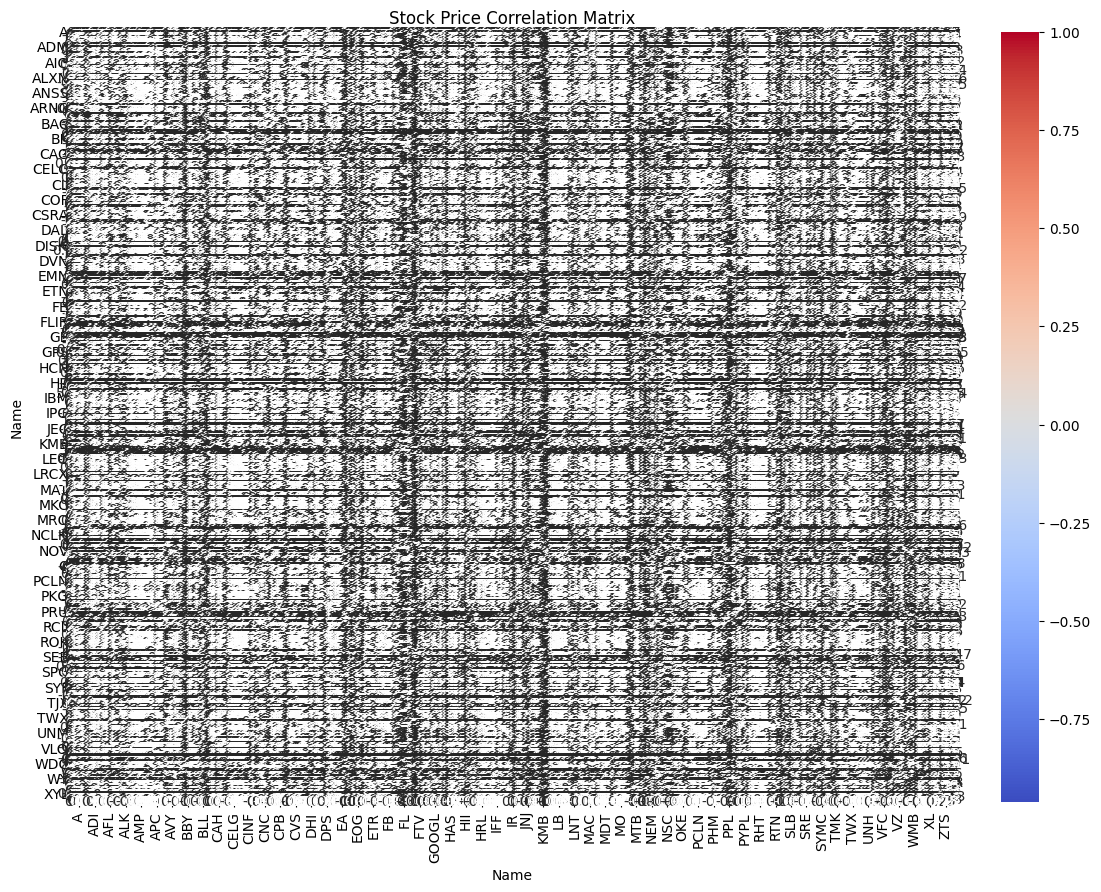

In [ ]:
# 주식 간의 상관 관계를 분석하기 위해 seaborn을 가져옵니다.
import seaborn as sns

# 주식 간의 상관 관계를 분석하기 위해 피벗 테이블을 생성합니다.
# 'date'를 인덱스로, 'Name'을 열로, 'close'를 값으로 설정합니다.
corr_data = data.pivot(index='date', columns='Name', values='close').corr()

# 상관 관계를 시각화합니다.
plt.figure(figsize=(14, 10))
sns.heatmap(corr_data, annot=True, cmap='coolwarm')
plt.title('Stock Price Correlation Matrix')
plt.show()


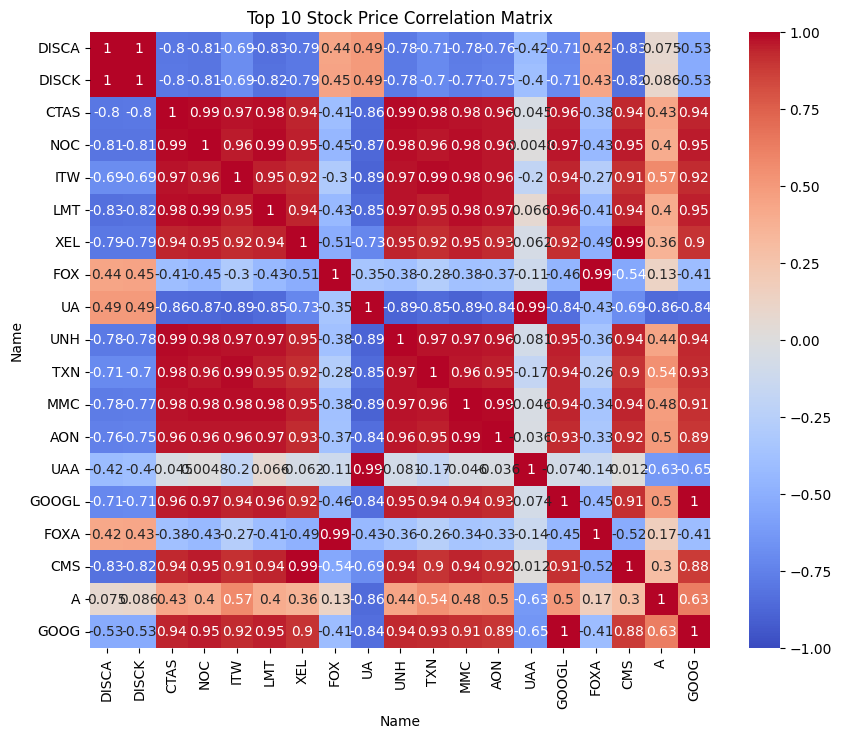

In [ ]:
# 상관 계수의 절댓값이 가장 큰 상위 10개 주식을 선택합니다.
corr_data = data.pivot(index='date', columns='Name', values='close').corr()
top_10_corr = corr_data.abs().unstack().sort_values(ascending=False).drop_duplicates().head(10)

# 상위 10개 주식의 이름을 추출합니다.
top_10_stocks = list(set(top_10_corr.index.get_level_values(0)).union(set(top_10_corr.index.get_level_values(1))))

# 상위 10개 주식만을 포함한 상관 행렬을 만듭니다.
top_10_corr_matrix = corr_data.loc[top_10_stocks, top_10_stocks]

# 상관 행렬을 시각화합니다.
plt.figure(figsize=(10, 8))
sns.heatmap(top_10_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 10 Stock Price Correlation Matrix')
plt.show()


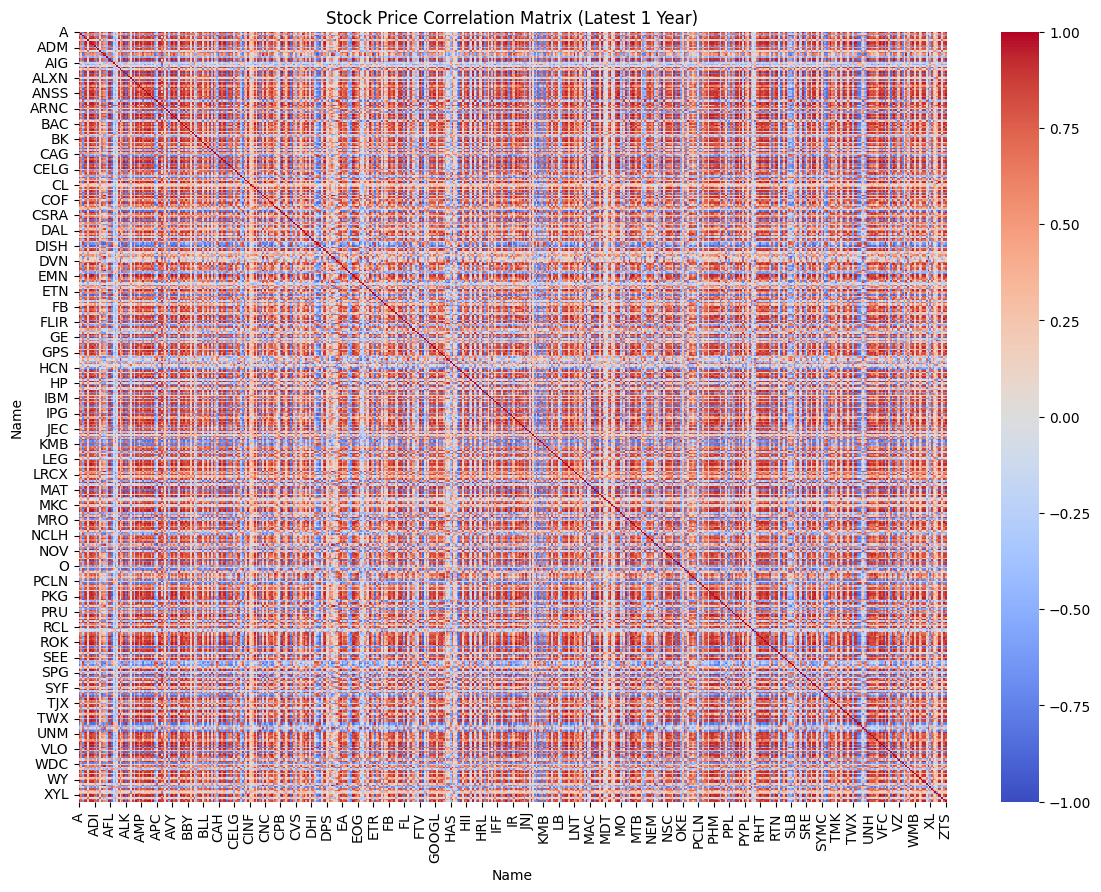

In [ ]:
# 'date' 컬럼을 datetime 타입으로 변환합니다.
data['date'] = pd.to_datetime(data['date'])

# 데이터의 최신 1년치를 선택합니다.
latest_year_data = data[data['date'] >= (data['date'].max() - pd.DateOffset(years=1))]

# 특정 기간 동안의 상관 행렬을 만듭니다.
latest_corr_data = latest_year_data.pivot(index='date', columns='Name', values='close').corr()

# 상관 행렬을 시각화합니다.
plt.figure(figsize=(14, 10))
sns.heatmap(latest_corr_data, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Stock Price Correlation Matrix (Latest 1 Year)')
plt.show()


In [ ]:
# 실제 주가와 예측된 주가를 비교하여 데이터프레임을 생성합니다.
predicted_df = pd.DataFrame({
    'Date': stock_data.index[-len(y_test):],
    'Actual': stock_data['close'][-len(y_test):].values,
    'Predicted': predicted_stock_price.flatten()
})

# 예측 결과를 'predicted_stock_prices.csv' 파일로 저장합니다.
predicted_df.to_csv('predicted_stock_prices.csv', index=False)
